In [2]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split

import basicest as b
import chemprop_ish as c
import delfos as d
import imp

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

RDKit WARNING: [17:22:03] Enabling RDKit 2019.09.3 jupyter extensions
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
data = pd.read_csv('non_aqueous_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

In [4]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
CV_datasets = b.data_maker(solute, solvent, pka, CV_ids)
datasets = b.data_maker(solute, solvent, pka)

In [78]:
imp.reload(b)

<module 'basicest' from '/Users/u6676643/codes/testing/basicest.py'>

In [81]:
DMPNN = b.Model(name='D-MPNN',
                model=c.double_MPNN(atom_messages=False),
                model_type='torch',
                data_type='SMILES')
DMPNN_att = b.Model(name='D-MPNN with attention',
                    model=c.double_MPNN(atom_messages=False, interaction=True),
                    model_type='torch',
                    data_type='SMILES')
MPNN = b.Model(name='MPNN',
                model=c.double_MPNN(atom_messages=True),
                model_type='torch',
                data_type='SMILES')
MPNN_att = b.Model(name='MPNN with attention',
                    model=c.double_MPNN(atom_messages=True, interaction=True),
                    model_type='torch',
                    data_type='SMILES')
RNN = b.Model(name='RNN+NN',
              model=d.dnet(interaction=False),
              model_type='torch',
              data_type='sentences')
RNN_att = b.Model(name='RNN+NN with attention',
                  model=d.dnet(),
                  model_type='torch',
                  data_type='sentences')

#list of all models for testing
models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att]

In [74]:
def training_loss(model,lr,batch_size,epochs):    
    train_ids = [x for x in range(893) if x not in holdout_ids]
    test_ids = holdout_ids
    
    data = datasets[model.data_type]
    scaler = b.pka_scaler(data[1][train_ids])
    loader = b.double_loader(data, indices=train_ids, batch_size=batch_size)
    
    regressor = copy.deepcopy(model.model)
    loss_function = torch.nn.MSELoss()
    #optimiser = model.optimiser
    optimiser = torch.optim.Adam(regressor.parameters(), lr=lr)

    test_loss_list = []
    train_loss_list = []
    for epoch in range(epochs):
        for (sol,solv,targets) in loader:
            targets = targets.view(-1,1)
            targets = scaler.transform(targets)
            optimiser.zero_grad()
            outputs = regressor(sol,solv)
            loss = loss_function(outputs, targets)
            print(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = b.test(model, regressor, train_ids, data, scaler)
        train_loss_list.append(train_loss[0])
        test_loss = b.test(model, regressor, test_ids, data, scaler)
        test_loss_list.append(test_loss[0])
    plt.plot(train_loss_list)
    plt.plot(test_loss_list)
    print(model.name)
    print("lr:",lr)
    print("batch size:", batch_size)
    print("epochs:", epochs)
    print("Test loss:", test_loss[0])
    print("Train loss:", train_loss[0])

In [76]:
def training_loss_early(model,lr,batch_size):
    data = datasets[model.data_type]
    train_ids = [x for x in range(893) if x not in holdout_ids]
    test_ids = holdout_ids
    solvent = [datasets['SMILES'][0][x][1] for x in train_ids]
    train_ids, val_ids, _, _ = train_test_split(train_ids, solvent, test_size=0.2, random_state=1, stratify=solvent)
    scaler = b.pka_scaler(data[1][train_ids])
    train_loader = b.double_loader(data, train_ids, batch_size=model.batch_size)
    val_loader = b.double_loader(data, val_ids, batch_size=len(val_ids))
    test_loader = b.double_loader(data, test_ids, batch_size=len(test_ids))
    
    regressor = copy.deepcopy(model.model)      
    optimiser = torch.optim.Adam(regressor.parameters(), lr=lr)
    loss_function = torch.nn.MSELoss()
    early_stopping = b.EarlyStopping(patience=10)
    
    train_losses = []
    val_losses = []
    test_losses = []
    train_MAE_list = []
    test_MAE_list = []
    
    for epoch in range(10):
        #train
        e_train_losses = []
        for (sol,solv,targets) in train_loader:
            targets = targets.view(-1,1)
            targets = scaler.transform(targets)
            optimiser.zero_grad()
            outputs = regressor(sol,solv)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimiser.step()
            e_train_losses.append(loss.item())
        train_losses.append(np.mean(e_train_losses))
        #evaluate
        for (sol,solv,targets) in val_loader:
            targets = targets.view(-1,1)
            targets = scaler.transform(targets)
            outputs = regressor(sol,solv)
            loss = loss_function(outputs, targets)
            val_loss = loss.item()
            val_losses.append(loss)
        #test
        for (sol,solv,targets) in test_loader:
            targets = targets.view(-1,1)
            targets = scaler.transform(targets)
            outputs = regressor(sol,solv)
            loss = loss_function(outputs, targets)
            test_loss = loss.item()
            test_losses.append(test_loss)
        train_MAE = b.test(model, regressor, train_ids, data, scaler)
        train_MAE_list.append(train_MAE[0])
        test_MAE = b.test(model, regressor, test_ids, data, scaler)
        test_MAE_list.append(test_MAE[0])
        #early stopping
        early_stopping.store(val_loss, regressor)
        if early_stopping.stop:
            print("stop")
            #break
    regressor.load_state_dict(torch.load('checkpoint.pt'))
    
    #final testing
    for (sol,solv,targets) in test_loader:
        outputs = regressor(sol,solv)
        outputs = scaler.inverse_transform(outputs)
        targets= targets.detach().numpy()
        outputs = outputs.detach().numpy()
        
    results = b.mae(targets, outputs)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.plot(test_losses)
    plt.show()
    plt.plot(train_MAE_list)
    plt.plot(test_MAE_list)
    plt.show()
    print(model.name)
    print("lr:",lr)
    print("batch size:", batch_size)
    print("epochs:", epoch)
    print("Final test MAE:"+str(results))

1.2214558124542236
1.74800443649292
0.8524612784385681
0.3633928596973419
0.8699923157691956
1.076320767402649
0.5213273763656616
1.1848541498184204
0.44677579402923584
0.5172734260559082
0.504776656627655
0.7814615964889526
0.5201511383056641
0.2739614248275757
0.47424668073654175
0.475894570350647
2.084979295730591
0.47402212023735046
1.5577547550201416
0.8343185782432556
1.849916696548462
1.8207859992980957
2.1064090728759766
1.1235265731811523
1.0926179885864258
0.6639650464057922
0.2891247868537903
0.6162397861480713
0.8297015428543091
0.384285569190979
1.176617980003357
0.4842829704284668
0.4583740830421448
0.3760779798030853
0.6188770532608032
0.4610280990600586
0.24789275228977203
0.27289310097694397
0.48918840289115906
1.1828210353851318
0.393138587474823
1.0649744272232056
0.7390491962432861
1.6651068925857544
1.1338579654693604
1.3824875354766846
0.7346917986869812
0.7905589938163757
0.4051773250102997
0.10338737070560455
0.3926806151866913
0.5193887948989868
0.2200656682252

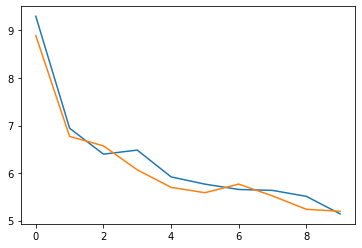

In [75]:
training_loss(MPNN,1e-3,32,10)

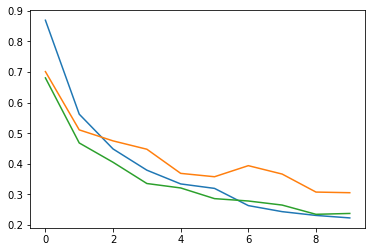

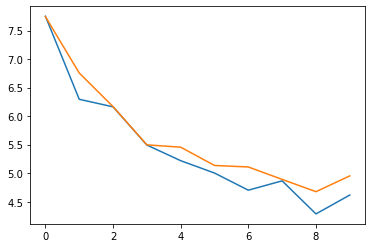

MPNN
lr: 0.001
batch size: 32
epochs: 9
Final test MAE:4.729227


In [77]:
training_loss_early(MPNN,1e-3,32)

In [82]:
exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = b.fit(m, data, holdout_ids, exp_name, datasets)
    
    print(res[0])
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

holdout_test = pd.DataFrame(results)
print(holdout_test)

testing D-MPNN ...
2.6454844
testing D-MPNN with attention ...
9.889985
testing MPNN ...
3.0239518
testing MPNN with attention ...
3.4183898
testing RNN+NN ...
1.8424523
testing RNN+NN with attention ...
2.0211954
                   Model   MAE   RMSE
0                 D-MPNN 2.645  3.509
1  D-MPNN with attention 9.890 13.430
2                   MPNN 3.024  4.045
3    MPNN with attention 3.418  4.482
4                 RNN+NN 1.842  2.724
5  RNN+NN with attention 2.021  2.853


In [83]:
results = ddict(list)
results['targets'] = datasets['ECFP'][1]
for m in models:
    data = datasets[m.data_type]
    _, outputs = b.predict(m, m.experiments[0], data)
    results[m.name] = outputs.reshape(893,)
    
output_results = pd.DataFrame(results)
print(output_results)
output_results.to_csv('DL_outputs.csv')

     targets  D-MPNN  D-MPNN with attention   MPNN  MPNN with attention  \
0      8.800   8.364                 14.046  9.986               10.983   
1     43.600  39.611                 21.353 44.775               33.406   
2     13.500  14.214                 11.936 12.097                9.906   
3      7.960   9.030                 13.014  8.383               10.062   
4     10.100   9.324                 12.572  9.143                4.939   
..       ...     ...                    ...    ...                  ...   
888   32.200  27.122                 28.349 22.070               27.214   
889    3.380   5.100                  9.943  4.759                4.363   
890   34.700  40.035                 25.290 28.957               31.525   
891   42.800  36.460                 19.248 35.942               32.097   
892    7.467   4.532                  8.546  6.366                6.627   

     RNN+NN  RNN+NN with attention  
0     8.151                  8.220  
1    41.929              

In [24]:
MPNN.lr

0.001

In [169]:
imp.reload(d)

<module 'delfos' from '/Users/u6676643/codes/testing/delfos.py'>

In [162]:
x1 = b.Model(name='sum',
              model=d.dnet(interaction=False,readout='sum'),
              model_type='torch',
              data_type='sentences')
x2 = b.Model(name='mean',
              model=d.dnet(interaction=False,readout='mean'),
              model_type='torch',
              data_type='sentences')
x3 = b.Model(name='max',
              model=d.dnet(interaction=False,readout='max'),
              model_type='torch',
              data_type='sentences')
x4 = b.Model(name='sum with attention',
                  model=d.dnet(readout='sum'),
                  model_type='torch',
                  data_type='sentences')
x5 = b.Model(name='mean with attention',
                  model=d.dnet(readout='mean'),
                  model_type='torch',
                  data_type='sentences')
x6 = b.Model(name='max with attention',
                  model=d.dnet(readout='max'),
                  model_type='torch',
                  data_type='sentences')
models = [x1,x2,x3,x4,x5,x6]

In [163]:
exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = b.fit(m, data, holdout_ids, exp_name, datasets)
    
    print(res[0])
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

holdout_test = pd.DataFrame(results)
print(holdout_test)

testing sum ...
2.679142
testing mean ...
2.8302875
testing max ...
2.379019
testing sum with attention ...
3.5918658
testing mean with attention ...
2.624299
testing max with attention ...
1.9237218
                 Model   MAE  RMSE
0                  sum 2.679 3.509
1                 mean 2.830 3.592
2                  max 2.379 3.332
3   sum with attention 3.592 4.624
4  mean with attention 2.624 3.587
5   max with attention 1.924 2.830


In [176]:
x1 = b.Model(name='exp + mean',
              model=d.dnet(interaction='exp',readout='mean',dropout=0),
              model_type='torch',
              data_type='sentences')
x2 = b.Model(name='tanh + mean',
              model=d.dnet(interaction='tanh',readout='mean'),
              model_type='torch',
              data_type='sentences')
x3 = b.Model(name='exp + max',
              model=d.dnet(interaction='exp',readout='max'),
              model_type='torch',
              data_type='sentences')
x4 = b.Model(name='tanh + max',
              model=d.dnet(interaction='tanh',readout='max'),
              model_type='torch',
              data_type='sentences')
models = [x1,x2,x3,x4]

exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = b.fit(m, data, holdout_ids, exp_name, datasets)
    
    print(res[0])
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

holdout_test = pd.DataFrame(results)
print(holdout_test)

testing exp + mean ...


KeyboardInterrupt: 

In [175]:
c1 = b.Model(name='exp + mean',
                model=c.double_MPNN(atom_messages=False, interaction='exp', readout='mean'),
                model_type='torch',
                data_type='SMILES')
c2 = b.Model(name='exp + max',
                    model=c.double_MPNN(atom_messages=False, interaction='exp', readout='max'),
                    model_type='torch',
                    data_type='SMILES')
c3 = b.Model(name='tanh + mean',
                model=c.double_MPNN(atom_messages=False, interaction='tanh', readout='mean'),
                model_type='torch',
                data_type='SMILES')
c4 = b.Model(name='tanh + max',
                    model=c.double_MPNN(atom_messages=False, interaction='tanh', readout='max'),
                    model_type='torch',
                    data_type='SMILES')
c5 = b.Model(name='max',
                    model=c.double_MPNN(atom_messages=False, interaction=None, readout='max'),
                    model_type='torch',
                    data_type='SMILES')
models = [c1,c2,c3,c4,c5]

exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = b.fit(m, data, holdout_ids, exp_name, datasets)
    
    print(res[0])
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

holdout_test = pd.DataFrame(results)
print(holdout_test)

testing exp + mean ...
2.7062013
testing exp + max ...
2.3312593
testing tanh + mean ...
2.874346
testing tanh + max ...
2.79277
testing max ...
2.6897938
         Model   MAE  RMSE
0   exp + mean 2.706 3.781
1    exp + max 2.331 3.122
2  tanh + mean 2.874 3.824
3   tanh + max 2.793 3.656
4          max 2.690 3.582


In [174]:
imp.reload(c)

<module 'chemprop_ish' from '/Users/u6676643/codes/testing/chemprop_ish.py'>